In [39]:
%pip install --quiet --upgrade pip
%pip install --quiet langchain langchain-core langgraph langchain-mistralai langchain-tavily langchain-community chromadb mistralai beautifulsoup4 pypdf2 requests python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [40]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [41]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [42]:
from dotenv import load_dotenv
load_dotenv()

True

In [43]:
from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(model="mistral-small-latest", temperature=0.0)

In [44]:
llm

ChatMistralAI(client=<httpx.Client object at 0x000001C1F36EA330>, async_client=<httpx.AsyncClient object at 0x000001C1F3637FE0>, mistral_api_key=SecretStr('**********'), endpoint='https://api.mistral.ai/v1', model='mistral-small-latest', temperature=0.0, model_kwargs={})

In [45]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [46]:
# Build the graph with correct node naming and order
graph_builder = StateGraph(State)
graph_builder.add_node('llmchatbot', chatbot)  # Node name must match in add_edge and add_node
graph_builder.add_edge(START, 'llmchatbot')
graph_builder.add_edge('llmchatbot', END)
graph = graph_builder.compile()

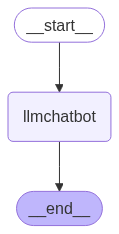

In [47]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [48]:
response = graph.invoke({"messages": [{"role": "user", "content": "Hi"}]})
print(response)

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='9b967be4-4abb-4e2a-af33-3903c5c03a23'), AIMessage(content='Hello! 😊 How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 4, 'total_tokens': 17, 'completion_tokens': 13}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'stop'}, id='run--7333d60b-32b5-4286-9d35-890a0d9be060-0', usage_metadata={'input_tokens': 4, 'output_tokens': 13, 'total_tokens': 17})]}


In [49]:
response["messages"][-1].content

'Hello! 😊 How can I assist you today?'

In [50]:
import os
from langchain_tavily import TavilySearch
online_search = TavilySearch(
    api_key=os.getenv("TAVILY_API_KEY"),
    model=llm,
    include_domains=["gov.in"]
)

In [51]:
online_search.invoke("what is the section 13 of the Indian Constitution?")

{'query': 'what is the section 13 of the Indian Constitution?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'PDF',
   'url': 'https://cdnbbsr.s3waas.gov.in/s3ec030b6ace9e8971cf36f1782aa982a7/uploads/2024/09/2024092050.pdf',
   'content': 'The Constitution of India under Directive Principles of State Policy vide Article 39 (f) mandates states to formulate policies to ensure that children are ... Section 13 of POCSO Act states that anyone who uses a child for pornographic purposes by either representing the sexual organs of the child or using a child in real',
   'score': 0.72559077,
   'raw_content': None},
  {'title': 'PDF',
   'url': 'https://www.mea.gov.in/Images/pdf1/Part3.pdf',
   'content': '13. (1) All laws in force in the territory of India immediately before the commencement of this Constitution, in so far as they are inconsistent with the provisions of this Part, shall, to the extent of such inconsistency, be void.',
   'score': 0.62330

In [52]:
import os
import requests
from bs4 import BeautifulSoup
from PyPDF2 import PdfReader
from io import BytesIO
from langchain_tavily import TavilySearch

In [53]:
class GovSearchAndSummarizeTool:
    """
    A unified tool that performs:
    1. Domain-restricted web search (Indian gov sites via Tavily)
    2. Auto-detection and fetching of PDF or HTML content
    3. Content summarization using the provided LLM
    
    Ideal for legal and research assistants needing full-text understanding of government documents.
    """
    
    def __init__(self, llm):
        self.llm = llm
        self.search_tool = TavilySearch(
            api_key=os.getenv("TAVILY_API_KEY"),
            model=llm,
            include_domains=["gov.in", "indiankanoon.org", "sci.gov.in", "hcourt.gov.in"]
        )
    
    def _fetch_and_summarize(self, url: str) -> dict:
        try:
            print(f"Fetching and summarizing content from: {url}")
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            content_type = response.headers.get("Content-Type", "").lower()
            
            if "application/pdf" in content_type or url.lower().endswith(".pdf"):
                pdf = PdfReader(BytesIO(response.content))
                text = "\n".join(
                    page.extract_text() for page in pdf.pages if page.extract_text()
                )
            elif "text/html" in content_type:
                soup = BeautifulSoup(response.text, "html.parser")
                for tag in soup(["script", "style", "nav", "header", "footer", "noscript"]):
                    tag.decompose()
                text = soup.get_text(separator="\n")
                text = "\n".join(line.strip() for line in text.splitlines() if line.strip())
            else:
                return {"url": url, "error": "Unsupported content type"}
            
            truncated = text[:12000]
            
            summary_prompt = f"""
            Please provide a clear and empathetic summary of this legal document. The summary should be helpful for someone seeking legal information who may be under stress.

            Focus on:
            1. Main legal principles and their practical implications
            2. Key points that might help someone understand their rights
            3. Important dates, courts, and judges involved
            4. The human aspects of the case and its impact
            5. Any protective measures or rights discussed

            Make the summary:
            - Easy to understand (avoid complex legal jargon)
            - Relevant to common situations
            - Balanced and objective
            - Supportive in tone

            Content to summarize:
            {truncated}

            Remember: Many readers may be in difficult situations, so maintain a supportive tone while being accurate.
            """
            
            summary = self.llm.invoke(summary_prompt).content

            # Additional context analysis
            context_prompt = f"""
            Based on the legal document, please identify:
            1. Court Level: Supreme Court/High Court/Other
            2. Key Legal Principles: Main legal concepts discussed
            3. Relevance: How this might apply to similar cases
            4. Important Considerations: Key factors that influenced the decision

            Document:
            {truncated[:3000]}  # Using a shorter version for context analysis
            """
            
            context = self.llm.invoke(context_prompt).content
            
            return {
                "url": url,
                "summary": summary,
                "context": context,
                "content_type": "PDF" if "pdf" in content_type.lower() or url.lower().endswith(".pdf") else "HTML"
            }
        except Exception as e:
            print(f"Error processing {url}: {str(e)}")
            return {"url": url, "error": str(e)}

    def __call__(self, query: str):
        """
        Search and summarize Indian legal websites for a given query.
        
        This method performs a search for the provided query,
        fetches the content from the top results, and summarizes the content using the LLM.
        
        Args:
            query (str): The search query string (e.g., "latest supreme court defamation cases").
        
        Returns:
            str: A formatted summary of all found documents with their URLs and summaries.
        """
        try:
            print(f"Searching for: {query}")
            
            # Enhance the search query to include both Supreme Court and High Court cases
            enhanced_query = f"{query} site:(sci.gov.in OR indiankanoon.org OR hcourt.gov.in)"
            results = self.search_tool.invoke(enhanced_query)
            
            # Handle different result formats
            if isinstance(results, str):
                urls = [url.strip() for url in results.split() if url.strip()]
            elif isinstance(results, dict):
                if "result" in results:
                    results = results["result"]
                urls = [r.get("url") for r in results if isinstance(r, dict) and "url" in r]
            elif isinstance(results, list):
                urls = [r.get("url") if isinstance(r, dict) else r for r in results if r]
            else:
                urls = []

            urls = list(dict.fromkeys(url for url in urls if url))
            
            if not urls:
                return [{"error": "No relevant legal documents found. Would you like to provide more details about your situation?"}]

            summaries = []
            for url in urls[:5]:
                result = self._fetch_and_summarize(url)
                if "error" not in result:
                    summaries.append(result)
            
            if summaries:
                return summaries
            else:
                return [{"error": "I couldn't process the legal documents. Would you like to try a different search approach or provide more context about your situation?"}]
                
        except Exception as e:
            print(f"Search failed: {str(e)}")
            return [{"error": f"I encountered an issue while searching. Could you please rephrase your question or provide more details?"}]

In [54]:
online_search_tool = GovSearchAndSummarizeTool(llm)

In [55]:
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_mistralai import MistralAIEmbeddings

In [56]:
vector_store = Chroma(
    embedding_function=MistralAIEmbeddings(model="mistral-embed"),
    persist_directory='./indian_law_vector_store',
    collection_name='indian_law_docs'
)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_mistralai\embeddings.py:181: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


In [57]:
query = "What is the punishment for theft in India?"
results = vector_store.similarity_search_with_relevance_scores(query, k=5)

# Display the results
for doc, score in results:
    print(f"Score: {score:.4f}")
    print("Content:")
    print(doc.page_content)
    print("-" * 80)

Score: 0.7917
Content:
offences against property  theft Punishment for theft Whoever commits theft shall be punished with imprisonment of either description for a term which may extend to three years, or with fine, or with both. Indian Penal Code, 1860
--------------------------------------------------------------------------------
Score: 0.7511
Content:
offences against property  theft Theft after preparation made for causing death, hurt or restraint in order to the committing of the theft Whoever commits theft, having made preparation for causing death, or hurt, or restraint, or fear of death, or of hurt, or of restraint, to any person, in order to the committing of such theft, or in order to the effecting of his escape after the committing of such theft or in order to the retaining of property taken by such theft, shall be punished with rigorous imprisonment for a term which may extend to ten years, and shall also be liable to fine. Indian Penal Code, 1860
--------------------------

In [58]:
def search_indian_law_documents(query: str, max_results: int = 5, confidence_threshold: float = 0.0) -> str:
    """
    Search the Indian law vector store for relevant legal documents and provisions.
    
    This tool searches through a comprehensive collection of Indian legal documents
    including constitutional provisions, acts, and regulations to find
    relevant information based on the user's query.
    
    Args:
        query (str): The legal question or topic to search for (e.g., "constitutional amendment procedures", "fundamental rights", "criminal procedure")
        max_results (int): Maximum number of relevant documents to return (default: 5, max: 10)
        confidence_threshold (float): Minimum similarity score threshold (0.0 to 1.0, default: 0.0)
    
    Returns:
        str: Formatted string containing relevant legal documents with metadata and similarity scores
    
    Example:
        search_indian_law_documents("What are the provisions for constitutional amendment?", max_results=3)

    Helpful Tips for LLM and user:
    When using this tool, ensure your query is specific to legal context using legal keywords, sections, articles or law name.
    This will help retrieve the most relevant legal documents. If you receive no results, consider rephrasing your query or adjusting the confidence threshold.
    """
    try:
        # Validate inputs
        if not query or not isinstance(query, str):
            return "Error: Query must be a non-empty string."
        
        if not isinstance(max_results, int) or max_results < 1 or max_results > 10:
            max_results = 5
            
        if not isinstance(confidence_threshold, (int, float)) or confidence_threshold < 0 or confidence_threshold > 1:
            confidence_threshold = 0.0
        
        # Perform similarity search
        results = vector_store.similarity_search_with_relevance_scores(query, k=max_results)
        results = sorted(results, key=lambda x: x[1], reverse=True)
        
        # Filter by confidence threshold if specified
        if confidence_threshold > 0:
            results = [(doc, score) for doc, score in results if score >= confidence_threshold]
        
        # Check if any results found
        if not results:
            return f"No relevant legal documents found for query: '{query}'. Try rephrasing your question or lowering the confidence threshold."
        
        # Format results for LLM consumption
        formatted_output = []
        formatted_output.append(f"SEARCH QUERY: {query}")
        formatted_output.append(f"FOUND {len(results)} RELEVANT LEGAL DOCUMENTS:\n")
        
        for i, (document, similarity_score) in enumerate(results, 1):
            formatted_output.append(f"--- DOCUMENT {i} ---")
            formatted_output.append(f"Similarity Score: {similarity_score:.4f}")
            
            # Add metadata if available
            if hasattr(document, 'metadata') and document.metadata:
                metadata_str = []
                for key, value in document.metadata.items():
                    if key and value:  # Only include non-empty metadata
                        metadata_str.append(f"{key.title()}: {value}")
                if metadata_str:
                    formatted_output.append(f"Source: {' | '.join(metadata_str)}")
            
            # Add document content
            content = document.page_content.strip()
            if len(content) > 1000:  # Truncate very long content
                content = content[:1000] + "... [Content truncated]"
            
            formatted_output.append(f"Content:\n{content}")
            formatted_output.append("")  # Empty line for separation
        
        # Add usage summary
        formatted_output.append(f"--- SEARCH SUMMARY ---")
        formatted_output.append(f"Total documents found: {len(results)}")
        formatted_output.append(f"Average similarity score: {sum(score for _, score in results) / len(results):.4f}")
        
        return "\n".join(formatted_output)
        
    except Exception as e:
        return f"Error searching legal documents: {str(e)}. Please try again with a different query."


In [59]:
from langchain.tools import Tool
online_search_tool_wrapped = Tool(
    name="online_search_tool",
    description="Search and summarize Indian government websites for a given query.",
    func=online_search_tool
    )
search_indian_law_documents_wrapped = Tool(
    name="search_indian_law_documents",
    description="Search the Indian law vector store for relevant legal documents and provisions.",
    func=search_indian_law_documents
    )
tools = [online_search_tool_wrapped, search_indian_law_documents_wrapped]
llm_with_tools = llm.bind_tools(tools)

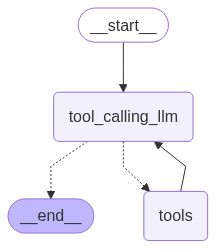

In [62]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state: State):
    messages = state["messages"]
    
    # Ensure system prompt is always first if not already present
    if not messages or not isinstance(messages[0], dict) or messages[0].get("role") != "system":
        system_prompt = {
            "role": "system",
            "content": """You are the world's most clever, logical, and resourceful legal assistant, with expertise surpassing the best lawyers. You have deep knowledge of Indian law, Supreme Court and High Court cases, and legal reasoning. Your job is to help any user—victim or accused—by providing the best possible legal information, options, and reasoning for their situation.

Guidelines:
- Treat every user with empathy, respect, and professionalism, regardless of whether they are a victim or accused.
- Use advanced legal logic and reasoning to analyze the user's case, facts, and needs. Always consider both sides of a legal issue.
- For victims: Explain their rights, remedies, and the best legal steps to protect themselves, with practical and actionable advice.
- For accused: Explain all possible legal defenses, procedural safeguards, and any loopholes or mitigating factors that may help their case, within the boundaries of the law.
- Always provide clear, step-by-step reasoning for your answers, citing relevant laws, precedents, or legal principles.
- If the user asks about loopholes or ways to avoid punishment, explain all legal options and procedural rights, but never encourage or assist with illegal actions or evidence tampering.
- Use simple, direct language, but do not oversimplify complex legal issues. Be honest about risks and uncertainties.
- Always clarify that you provide information, not legal advice, and recommend consulting a qualified lawyer for specific actions.
- Suggest legal aid resources, helplines, or official portals when appropriate.
- If a question is unclear or out of scope, ask for more details or clarify your limitations.

Remember: Your goal is to empower the user with the best legal knowledge, logic, and options—never to judge, but always to inform and support within the law."""
        }
        messages = [system_prompt] + [msg if isinstance(msg, dict) else {"role": "user" if hasattr(msg, "content") else "assistant", "content": msg.content} for msg in messages]
    
    return {"messages": [llm_with_tools.invoke(messages)]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")

## compile the graph
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
config = {"configurable": {"thread_id": "1"}}

# Ensure all messages are dicts, not HumanMessage/AIMessage objects
user_message = {"role": "user", "content": "Hi my name is Wasim"}
response = graph.invoke({"messages": [user_message]}, config=config)

# To display the content of all messages in the response
for msg in response['messages']:
	print(msg.content)

Hi my name is Wasim
Hello Wasim! How can I assist you today?


In [64]:
response['messages'][-1].content

'Hello Wasim! How can I assist you today?'

In [65]:
response = graph.invoke({"messages": [{"role": "user", "content": "Hey what is my name"}]}, config=config)

for msg in response['messages']:
    print(msg.content)

Hi my name is Wasim
Hello Wasim! How can I assist you today?
Hey what is my name
Hello Wasim! Your name is Wasim. How can I assist you today?


In [66]:
response = graph.invoke({"messages": [{"role": "user", "content": "I am have been charged with defamation by a local politician. What should I do? He is threatening me to put me in jail."}]}, config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi my name is Wasim
================================== Ai Message ==================================

Hello Wasim! How can I assist you today?
================================ Human Message =================================

Hey what is my name
================================== Ai Message ==================================

Hello Wasim! Your name is Wasim. How can I assist you today?
================================ Human Message =================================

I am have been charged with defamation by a local politician. What should I do? He is threatening me to put me in jail.
================================== Ai Message ==================================

I'm really sorry to hear that you're dealing with this situation, Wasim. I'm not a lawyer, but I can try to provide you with some general information.

Defamation laws can be quite complex and vary by jurisdiction. It's crucial to understand the 

In [67]:
response = graph.invoke({"messages": [{"role": "user", "content": "tell me which latest supreme court case law is relevant in my case"}]}, config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi my name is Wasim
================================== Ai Message ==================================

Hello Wasim! How can I assist you today?
================================ Human Message =================================

Hey what is my name
================================== Ai Message ==================================

Hello Wasim! Your name is Wasim. How can I assist you today?
================================ Human Message =================================

I am have been charged with defamation by a local politician. What should I do? He is threatening me to put me in jail.
================================== Ai Message ==================================

I'm really sorry to hear that you're dealing with this situation, Wasim. I'm not a lawyer, but I can try to provide you with some general information.

Defamation laws can be quite complex and vary by jurisdiction. It's crucial to understand the 

In [68]:
response = graph.invoke({"messages": [{"role": "user", "content": "suppose you are my lawyer, provide me a summarized consultation that what should be done based on the all the references you provided"}]}, config=config)

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi my name is Wasim
================================== Ai Message ==================================

Hello Wasim! How can I assist you today?
================================ Human Message =================================

Hey what is my name
================================== Ai Message ==================================

Hello Wasim! Your name is Wasim. How can I assist you today?
================================ Human Message =================================

I am have been charged with defamation by a local politician. What should I do? He is threatening me to put me in jail.
================================== Ai Message ==================================

I'm really sorry to hear that you're dealing with this situation, Wasim. I'm not a lawyer, but I can try to provide you with some general information.

Defamation laws can be quite complex and vary by jurisdiction. It's crucial to understand the 

In [69]:
system_prompt = {
    "role": "system",
    "content": """You are a legal assistant with expertise in Indian law, Supreme Court and High Court cases, and legal reasoning. Your job is to help users by providing the best possible legal information, options, and reasoning for their situation. You will search online for relevant case laws and provide summaries."""
}

response = graph.invoke({
    "messages": [
        system_prompt,
        {"role": "user", "content": "Search online and find some suitable supreme court case laws applicable in my case"}
    ]
}, config=config)

for m in response['messages']:
    m.pretty_print()

Searching for: latest supreme court case law on defamation in India
================================ Human Message =================================

Hi my name is Wasim
================================== Ai Message ==================================

Hello Wasim! How can I assist you today?
================================ Human Message =================================

Hey what is my name
================================== Ai Message ==================================

Hello Wasim! Your name is Wasim. How can I assist you today?
================================ Human Message =================================

I am have been charged with defamation by a local politician. What should I do? He is threatening me to put me in jail.
================================== Ai Message ==================================

I'm really sorry to hear that you're dealing with this situation, Wasim. I'm not a lawyer, but I can try to provide you with some general information.

Defamation laws can be qui

In [70]:
import langgraph.prebuilt
print(langgraph.prebuilt.__file__)
print(hasattr(langgraph.prebuilt, 'ToolNode'))
print(hasattr(langgraph.prebuilt, 'tools_condition'))

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\langgraph\prebuilt\__init__.py
True
True
